<a href="https://colab.research.google.com/github/Mehrandibi/AfES/blob/main/RNN-basedDemandForecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
from google.colab import drive
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error, accuracy_score, precision_score
import matplotlib.pyplot as plt

# 1. Mount Google Drive
drive.mount('/content/drive')

# 2. Define data directory and load CSV files
data_dir = '/content/drive/MyDrive/AI for Energy course/Capstone/Group Data/'  # Update with your data directory
features = {}

for filename in os.listdir(data_dir):
    if filename.startswith('feature_df.brendan.') and filename.endswith('.csv'):
        region_name = filename.split('brendan.')[1].split('.csv')[0]
        filepath = os.path.join(data_dir, filename)
        try:
            features[region_name] = pd.read_csv(filepath)
            features[region_name] = features[region_name].iloc[:, 1:]
        except pd.errors.ParserError as e:
            print(f"Error parsing file {filename}: {e}")
        except Exception as e:
            print(f"An unexpected error occurred while reading {filename}: {e}")

        print(f'Loaded: {filepath} into {region_name}')

# 3. Define functions for data preparation and forecasting
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

def forecast_demand_rnn(df, region_name, forecast_horizon=365*5):  # Extended forecast horizon (5 years)
    # Preprocess data
    dataset = df[['datetime', 'demand']].copy()
    dataset['datetime'] = pd.to_datetime(dataset['datetime'])
    dataset.set_index('datetime', inplace=True)
    dataset = dataset.values.astype('float32')

    # Scale data
    scaler = MinMaxScaler(feature_range=(0, 1))
    dataset = scaler.fit_transform(dataset)

    # Split into train and test sets
    train_size = int(len(dataset) * 0.67)
    test_size = len(dataset) - train_size
    train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]

    # Create dataset with look_back
    look_back = 1
    X_train, y_train = create_dataset(train, look_back)
    X_test, y_test = create_dataset(test, look_back)

    # Reshape input to be [samples, time steps, features]
    X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
    X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

    # Create and fit the RNN network
    model = Sequential()
    model.add(LSTM(units=100, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(0.2))
    model.add(LSTM(units=100))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    history = model.fit(X_train, y_train, epochs=300, batch_size=64, verbose=2)

    # Make predictions
    train_predict = model.predict(X_train)
    test_predict = model.predict(X_test)

    # Invert predictions to original scale
    train_predict = scaler.inverse_transform(np.concatenate((train_predict, np.zeros((train_predict.shape[0], 1))), axis=1))[:, 0]
    y_train = scaler.inverse_transform(np.concatenate((y_train.reshape(-1, 1), np.zeros((y_train.shape[0], 1))), axis=1))[:, 0]
    test_predict = scaler.inverse_transform(np.concatenate((test_predict, np.zeros((test_predict.shape[0], 1))), axis=1))[:, 0]
    y_test = scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), np.zeros((y_test.shape[0], 1))), axis=1))[:, 0]

    # Calculate and print RMSE
    train_score = np.sqrt(mean_squared_error(y_train, train_predict))
    print(f'{region_name} Train Score: %.2f RMSE' % (train_score))
    test_score = np.sqrt(mean_squared_error(y_test, test_predict))
    print(f'{region_name} Test Score: %.2f RMSE' % (test_score))

    # Calculate and print accuracy and precision
    threshold = np.mean(y_test)
    y_test_binary = np.where(y_test > threshold, 1, 0)
    test_predict_binary = np.where(test_predict > threshold, 1, 0)

    accuracy = accuracy_score(y_test_binary, test_predict_binary)
    precision = precision_score(y_test_binary, test_predict_binary)

    print(f'{region_name} Accuracy: {accuracy:.2f}')
    print(f'{region_name} Precision: {precision:.2f}')

    # Get dates for plotting
    dates = pd.to_datetime(df['datetime'][train_size + look_back + 1:])

    # Forecasting (Extended)
    future_dates = pd.date_range(start=df['datetime'].iloc[-1], periods=forecast_horizon + 1, freq='D')[1:]
    future_inputs = dataset[-look_back:]
    future_inputs = future_inputs.reshape(1, 1, look_back)
    future_predictions = []

    for _ in range(forecast_horizon):
        prediction = model.predict(future_inputs)
        future_predictions.append(prediction[0, 0])
        future_inputs = np.append(future_inputs[:, :, 1:], prediction.reshape(1, 1, 1), axis=2)

    future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

    # Plotting with forecast (Extended)
    plt.plot(dates, y_test, label='Actual Demand')
    plt.plot(dates, test_predict, label='Predicted Demand')
    plt.plot(future_dates, future_predictions, label='Forecast', linestyle='--')  # Plot forecast
    plt.title(f'Demand Forecast for {region_name}')
    plt.xlabel('Date')
    plt.ylabel('Demand')
    plt.xticks(rotation=45, ha='right')
    plt.legend()
    plt.tight_layout()
    plt.show()


    # Plot loss function
    plt.plot(history.history['loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.show()

# 4. Run the forecast for each region
for region_name, df in features.items():
    forecast_demand_rnn(df, region_name, forecast_horizon=365*5)  # Using extended forecast horizon (5 years)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loaded: /content/drive/MyDrive/AI for Energy course/Capstone/Group Data/feature_df.brendan.northeast_mass.csv into northeast_mass


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/300
20/20 - 6s - 300ms/step - loss: 0.0858
Epoch 2/300
20/20 - 0s - 16ms/step - loss: 0.0246
Epoch 3/300
20/20 - 0s - 15ms/step - loss: 0.0159
Epoch 4/300
20/20 - 0s - 15ms/step - loss: 0.0128
Epoch 5/300
20/20 - 0s - 11ms/step - loss: 0.0104
Epoch 6/300
20/20 - 0s - 15ms/step - loss: 0.0086
Epoch 7/300
20/20 - 0s - 15ms/step - loss: 0.0078
Epoch 8/300
20/20 - 0s - 15ms/step - loss: 0.0072
Epoch 9/300
20/20 - 0s - 16ms/step - loss: 0.0073
Epoch 10/300
20/20 - 0s - 12ms/step - loss: 0.0074
Epoch 11/300
20/20 - 0s - 15ms/step - loss: 0.0077
Epoch 12/300
20/20 - 0s - 12ms/step - loss: 0.0075
Epoch 13/300
20/20 - 0s - 16ms/step - loss: 0.0076
Epoch 14/300
20/20 - 0s - 16ms/step - loss: 0.0073
Epoch 15/300
20/20 - 0s - 12ms/step - loss: 0.0077
Epoch 16/300
20/20 - 0s - 7ms/step - loss: 0.0074
Epoch 17/300
20/20 - 0s - 7ms/step - loss: 0.0074
Epoch 18/300
20/20 - 0s - 14ms/step - loss: 0.0074
Epoch 19/300
20/20 - 0s - 7ms/step - loss: 0.0073
Epoch 20/300
20/20 - 0s - 14ms/step - loss

In [ ]:
import os
from google.colab import drive
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error, accuracy_score, precision_score
import matplotlib.pyplot as plt

# 1. Mount Google Drive
drive.mount('/content/drive')

# 2. Define data directory and load CSV files
data_dir = '/content/drive/MyDrive/AI for Energy course/Capstone/Group Data/'
features = {}

for filename in os.listdir(data_dir):
    if filename.startswith('feature_df.brendan.') and filename.endswith('.csv'):
        region_name = filename.split('brendan.')[1].split('.csv')[0]
        filepath = os.path.join(data_dir, filename)
        try:
            features[region_name] = pd.read_csv(filepath)
            features[region_name] = features[region_name].iloc[:, 1:]
        except pd.errors.ParserError as e:
            print(f"Error parsing file {filename}: {e}")
        except Exception as e:
            print(f"An unexpected error occurred while reading {filename}: {e}")

        print(f'Loaded: {filepath} into {region_name}')

# 3. Define functions for data preparation and forecasting
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

def forecast_demand_rnn(df, region_name, forecast_horizon=30):
    # Preprocess data
    dataset = df[['datetime', 'demand']].copy()
    dataset['datetime'] = pd.to_datetime(dataset['datetime'])
    dataset.set_index('datetime', inplace=True)
    dataset = dataset.values.astype('float32')

    # Scale data
    scaler = MinMaxScaler(feature_range=(0, 1))
    dataset = scaler.fit_transform(dataset)

    # Split into train and test sets
    train_size = int(len(dataset) * 0.67)
    test_size = len(dataset) - train_size
    train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]

    # Create dataset with look_back
    look_back = 20
    X_train, y_train = create_dataset(train, look_back)
    X_test, y_test = create_dataset(test, look_back)

    # Reshape input to be [samples, time steps, features]
    X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
    X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

    # Create and fit the RNN network
    model = Sequential()
    model.add(LSTM(units=100, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(0.2))
    model.add(LSTM(units=100))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    history = model.fit(X_train, y_train, epochs=300, batch_size=64, verbose=2)

    # Make predictions
    train_predict = model.predict(X_train)
    test_predict = model.predict(X_test)

    # Invert predictions to original scale
    train_predict = scaler.inverse_transform(np.concatenate((train_predict, np.zeros((train_predict.shape[0], 1))), axis=1))[:, 0]
    y_train = scaler.inverse_transform(np.concatenate((y_train.reshape(-1, 1), np.zeros((y_train.shape[0], 1))), axis=1))[:, 0]
    test_predict = scaler.inverse_transform(np.concatenate((test_predict, np.zeros((test_predict.shape[0], 1))), axis=1))[:, 0]
    y_test = scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), np.zeros((y_test.shape[0], 1))), axis=1))[:, 0]

    # Calculate and print RMSE
    train_score = np.sqrt(mean_squared_error(y_train, train_predict))
    print(f'{region_name} Train Score: %.2f RMSE' % (train_score))
    test_score = np.sqrt(mean_squared_error(y_test, test_predict))
    print(f'{region_name} Test Score: %.2f RMSE' % (test_score))

    # Calculate and print accuracy and precision
    threshold = np.mean(y_test)
    y_test_binary = np.where(y_test > threshold, 1, 0)
    test_predict_binary = np.where(test_predict > threshold, 1, 0)

    accuracy = accuracy_score(y_test_binary, test_predict_binary)
    precision = precision_score(y_test_binary, test_predict_binary)

    print(f'{region_name} Accuracy: {accuracy:.2f}')
    print(f'{region_name} Precision: {precision:.2f}')

    # Get dates for plotting
    dates = pd.to_datetime(df['datetime'][train_size + look_back + 1:])

    # Forecasting
    future_dates = pd.date_range(start=df['datetime'].iloc[-1], periods=forecast_horizon + 1, freq='D')[1:]
    future_inputs = dataset[-look_back:]
    future_inputs = future_inputs.reshape(1, 1, look_back)
    future_predictions = []

    for _ in range(forecast_horizon):
        prediction = model.predict(future_inputs)
        future_predictions.append(prediction[0, 0])
        future_inputs = np.append(future_inputs[:, :, 1:], prediction.reshape(1, 1, 1), axis=2)

    future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

    # Plot results with forecast
    plt.plot(dates, y_test, label='Actual Demand')
    plt.plot(dates, test_predict, label='Predicted Demand')
    plt.plot(future_dates, future_predictions, label='Forecast', linestyle='--')  # Plot forecast
    plt.title(f'Demand Forecast for {region_name}')
    plt.xlabel('Date')
    plt.ylabel('Demand')
    plt.xticks(rotation=45, ha='right')
    plt.legend()
    plt.tight_layout()
    plt.show()


    # Plot loss function
    plt.plot(history.history['loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.show()

# 4. Run the forecast for each region
for region_name, df in features.items():
    forecast_demand_rnn(df, region_name, forecast_horizon=30)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loaded: /content/drive/MyDrive/AI for Energy course/Capstone/Group Data/feature_df.brendan.northeast_mass.csv into northeast_mass


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/300
20/20 - 6s - 325ms/step - loss: 0.0874
Epoch 2/300
20/20 - 0s - 9ms/step - loss: 0.0243
Epoch 3/300
20/20 - 0s - 14ms/step - loss: 0.0154
Epoch 4/300
20/20 - 0s - 8ms/step - loss: 0.0126
Epoch 5/300
20/20 - 0s - 15ms/step - loss: 0.0108
Epoch 6/300
20/20 - 0s - 8ms/step - loss: 0.0092
Epoch 7/300
20/20 - 0s - 8ms/step - loss: 0.0081
Epoch 8/300
20/20 - 0s - 8ms/step - loss: 0.0076
Epoch 9/300
20/20 - 0s - 7ms/step - loss: 0.0077
Epoch 10/300
20/20 - 0s - 7ms/step - loss: 0.0074
Epoch 11/300
20/20 - 0s - 15ms/step - loss: 0.0076
Epoch 12/300
20/20 - 0s - 15ms/step - loss: 0.0071
Epoch 13/300
20/20 - 0s - 15ms/step - loss: 0.0073
Epoch 14/300
20/20 - 0s - 20ms/step - loss: 0.0075
Epoch 15/300
20/20 - 0s - 13ms/step - loss: 0.0077
Epoch 16/300
20/20 - 0s - 15ms/step - loss: 0.0073
Epoch 17/300
20/20 - 0s - 13ms/step - loss: 0.0074
Epoch 18/300
20/20 - 0s - 14ms/step - loss: 0.0074
Epoch 19/300
20/20 - 0s - 16ms/step - loss: 0.0077
Epoch 20/300
20/20 - 0s - 15ms/step - loss: 0.

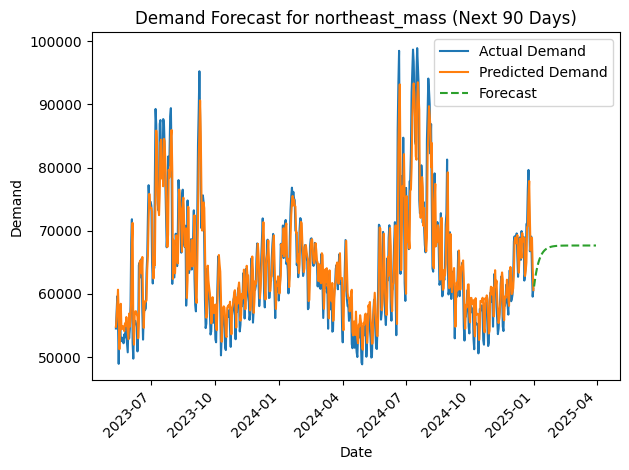

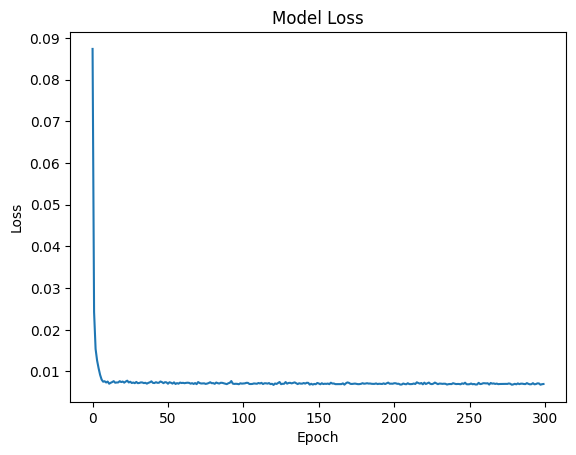

In [15]:
import os
from google.colab import drive
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error, accuracy_score, precision_score
import matplotlib.pyplot as plt

# 1. Mount Google Drive
drive.mount('/content/drive')

# 2. Define data directory and load CSV files
data_dir = '/content/drive/MyDrive/AI for Energy course/Capstone/Group Data/'  # Update with your data directory
features = {}

for filename in os.listdir(data_dir):
    if filename.startswith('feature_df.brendan.') and filename.endswith('.csv'):
        region_name = filename.split('brendan.')[1].split('.csv')[0]
        filepath = os.path.join(data_dir, filename)
        try:
            features[region_name] = pd.read_csv(filepath)
            features[region_name] = features[region_name].iloc[:, 1:]
        except pd.errors.ParserError as e:
            print(f"Error parsing file {filename}: {e}")
        except Exception as e:
            print(f"An unexpected error occurred while reading {filename}: {e}")

        print(f'Loaded: {filepath} into {region_name}')

# 3. Define functions for data preparation and forecasting
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

def forecast_demand_rnn(df, region_name, forecast_horizon=365*5, plot_horizon=90):  # Added plot_horizon
    # Preprocess data
    dataset = df[['datetime', 'demand']].copy()
    dataset['datetime'] = pd.to_datetime(dataset['datetime'])
    dataset.set_index('datetime', inplace=True)
    dataset = dataset.values.astype('float32')

    # Scale data
    scaler = MinMaxScaler(feature_range=(0, 1))
    dataset = scaler.fit_transform(dataset)

    # Split into train and test sets
    train_size = int(len(dataset) * 0.67)
    test_size = len(dataset) - train_size
    train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]

    # Create dataset with look_back
    look_back = 1
    X_train, y_train = create_dataset(train, look_back)
    X_test, y_test = create_dataset(test, look_back)

    # Reshape input to be [samples, time steps, features]
    X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
    X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

    # Create and fit the RNN network
    model = Sequential()
    model.add(LSTM(units=100, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(0.2))
    model.add(LSTM(units=100))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    history = model.fit(X_train, y_train, epochs=300, batch_size=64, verbose=2)

    # Make predictions
    train_predict = model.predict(X_train)
    test_predict = model.predict(X_test)

    # Invert predictions to original scale
    train_predict = scaler.inverse_transform(np.concatenate((train_predict, np.zeros((train_predict.shape[0], 1))), axis=1))[:, 0]
    y_train = scaler.inverse_transform(np.concatenate((y_train.reshape(-1, 1), np.zeros((y_train.shape[0], 1))), axis=1))[:, 0]
    test_predict = scaler.inverse_transform(np.concatenate((test_predict, np.zeros((test_predict.shape[0], 1))), axis=1))[:, 0]
    y_test = scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), np.zeros((y_test.shape[0], 1))), axis=1))[:, 0]

    # Calculate and print RMSE
    train_score = np.sqrt(mean_squared_error(y_train, train_predict))
    print(f'{region_name} Train Score: %.2f RMSE' % (train_score))
    test_score = np.sqrt(mean_squared_error(y_test, test_predict))
    print(f'{region_name} Test Score: %.2f RMSE' % (test_score))

    # Calculate and print accuracy and precision
    threshold = np.mean(y_test)
    y_test_binary = np.where(y_test > threshold, 1, 0)
    test_predict_binary = np.where(test_predict > threshold, 1, 0)

    accuracy = accuracy_score(y_test_binary, test_predict_binary)
    precision = precision_score(y_test_binary, test_predict_binary)

    print(f'{region_name} Accuracy: {accuracy:.2f}')
    print(f'{region_name} Precision: {precision:.2f}')

    # Get dates for plotting
    dates = pd.to_datetime(df['datetime'][train_size + look_back + 1:])

    # Forecasting (Extended)
    future_dates = pd.date_range(start=df['datetime'].iloc[-1], periods=forecast_horizon + 1, freq='D')[1:]
    future_inputs = dataset[-look_back:]
    future_inputs = future_inputs.reshape(1, 1, look_back)
    future_predictions = []

    for _ in range(forecast_horizon):
        prediction = model.predict(future_inputs)
        future_predictions.append(prediction[0, 0])
        future_inputs = np.append(future_inputs[:, :, 1:], prediction.reshape(1, 1, 1), axis=2)

    future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

    # Plotting with limited forecast horizon
    plt.plot(dates, y_test, label='Actual Demand')
    plt.plot(dates, test_predict, label='Predicted Demand')
    plt.plot(future_dates[:plot_horizon], future_predictions[:plot_horizon], label='Forecast', linestyle='--')  # Limited forecast plot
    plt.title(f'Demand Forecast for {region_name} (Next {plot_horizon} Days)')
    plt.xlabel('Date')
    plt.ylabel('Demand')
    plt.xticks(rotation=45, ha='right')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Plot full forecast (if needed) - You can uncomment this to see the full forecast
    # plt.plot(future_dates, future_predictions, label='Full Forecast', linestyle='--')
    # plt.title(f'Full Demand Forecast for {region_name} ({forecast_horizon} Days)')
    # # ... (rest of plotting code - same as before)


    # Plot loss function
    plt.plot(history.history['loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.show()

# 4. Run the forecast for each region
for region_name, df in features.items():
    forecast_demand_rnn(df, region_name, forecast_horizon=365*5, plot_horizon=90)  # Call with forecast and plot horizons